In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import random 
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from datetime import datetime

utils.reset_seeds(0)

In [81]:
def rmse_traindata(X_train, y_train, start, end, fn=lambda x: x**2):
    """Leiab antud piirkonnas asuvate treeningpunktide rmse väärtuse.

    :param X_train: treeningandmed X
    :param y_train: treeningandmed y
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: fn millega y saada, defaults to lambdax:x**2
    :return: rmse
    """

    # ehk kõik need väärtused kus X_train on vahemikus [start, end)
    X = X_train[np.logical_and(X_train >= start, X_train < end)]
    # ehk kõik need indeksid, kus X_train on vahemikus [start, end)
    y = y_train[np.where((X_train >= start)&(X_train < end))[0]]

    return np.sqrt(np.mean((y-fn(X))**2))

In [98]:
def rmse_estimate(model, X_train, start, end, fn=lambda x: x**2):
    """Leiab rmse treeningandmete põhjal, on võimalik anda ka ette vahemik (start, end), kus leitakse see rmse.

    :param model: mudel
    :param X_train: treeningandmed
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: default on x^2
    :return: rmse
    """
    
    X = X_train[np.logical_and(X_train >= start, X_train < end)]
    num = len(X)

    if num == 0:
        return 0
    assert num > 0, "No data in interval"
    y_pred = model.predict(X, verbose=False)
    variance = np.exp(y_pred[:, 1:])

    return np.sqrt(np.sum(variance)/num)


In [83]:
def rmse_estimate_grid(model, start, end, fn=lambda x:x**2, steps=5000):
    """Leiab gridi läbi käimisel mudeli rmse väärtuse.

    :param model: mudel
    :param start: algus (inclusive)
    :param end: lõpp (exclusive)
    :param fn: fn, defaults to lambdax:x**2
    :param steps: gridi peensus, defaults to 5000
    :return: rmse
    """    

    X = np.linspace(start, end, steps)
    y = model.predict(X, verbose=False)
    variance = np.exp(y[:, 1:])
    return np.sqrt(np.sum(variance)/steps)

In [84]:
def all_rmses(model, X_train, y_train, start, end, fn=lambda x: x**2, steps=5000):
    """rmse_traindata, rmse_estimate, rmse_estimate_grid mugavusfunk

    :param model: _description_
    :param X_train: _description_
    :param y_train: _description_
    :param start: _description_
    :param end: _description_
    :param fn: _description_, defaults to lambdax:x**2
    :param steps: _description_, defaults to 5000
    :return: _description_
    """    
    return rmse_traindata(X_train, y_train, start, end, fn), \
        rmse_estimate(model, X_train, start, end, fn), \
        rmse_estimate_grid(model, start, end, fn, steps)


In [122]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=5, activation='relu', name="layer_1"),
    layers.Dense(units=5, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])
X, y = utils.train_data_maker(
    [
    (-0.8, 0.1, 10, 0.1),
    (0.5, 0.2, 10, 0.3),
    (0.9, 0.1, 10, 0.1),
    ],
    fn=lambda x: x**2)

X_train, y_train = X, y
X_valid, y_valid = np.linspace(-1.2, 1.2,
                               10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, amsgrad=True, epsilon=0.001),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X, y, batch_size=8, epochs=2000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)


Epoch:   0 | Loss: 4.15958e-01
Epoch: 100 | Loss: -1.74653e+00
Epoch: 200 | Loss: -2.92304e+00
Epoch: 300 | Loss: -3.19827e+00
Epoch: 400 | Loss: -3.31420e+00
Epoch: 500 | Loss: -3.37907e+00
Epoch: 600 | Loss: -3.42264e+00
Epoch: 700 | Loss: -3.45317e+00
Epoch: 800 | Loss: -3.47374e+00
Epoch: 900 | Loss: -3.48380e+00
Epoch: 1000 | Loss: -3.50778e+00
Epoch: 1100 | Loss: -3.51915e+00
Epoch: 1200 | Loss: -3.52475e+00
Epoch: 1300 | Loss: -3.53424e+00
Epoch: 1400 | Loss: -3.53046e+00
Epoch: 1500 | Loss: -3.53638e+00
Epoch: 1600 | Loss: -3.54304e+00
Epoch: 1700 | Loss: -3.55169e+00
Epoch: 1800 | Loss: -3.54799e+00
Epoch: 1900 | Loss: -3.52365e+00


313/313 [==============================] - 1s 2ms/step
model contains 7 breaks
313/313 [==============================] - 1s 2ms/step


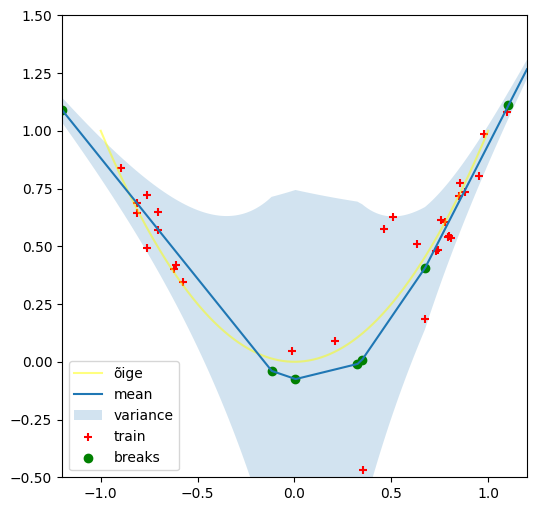

In [123]:
# X_train, y_train = utils.train_data_maker(
#     [
#         (-0.7, 0.2, 10, 0.3),
#         (-0.4, 0.1, 5, 0.1),
#         (0.4, 0.1, 5, 0.1),
#         (0.7, 0.2, 10, 0.3),
#     ],
#     fn=lambda x: x**2,
#     seed=2002
#     )
# X_train, y_train = utils.train_data_maker([
#     (-0.8, 0.1, 10, 0.1),
#     (0.5, 0.2, 10, 0.3),
#     (0.9, 0.1, 10, 0.1),
#     ])
utils.joonista_variance(model, X_valid, X_train, y_train, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))

In [132]:
np.sort(X_train)

array([-0.89772779, -0.81513572, -0.81032189, -0.75998428, -0.75894015,
       -0.70499116, -0.7021262 , -0.62359477, -0.6132442 , -0.57591068,
       -0.01059796,  0.20912687,  0.351567  ,  0.46256323,  0.5091517 ,
        0.63072372,  0.67288724,  0.72937298,  0.73861022,  0.75799821,
        0.77472046,  0.79387175,  0.7951447 ,  0.80655584,  0.84903478,
        0.85619257,  0.87872597,  0.95395092,  0.97774904,  1.09507754])

In [99]:
for start in np.linspace(-1.0, -0.07, 50):
    print(start, all_rmses(model, X_train, y_train, start, -0.069, fn=lambda x: x**2, steps=5000))

-1.0 (0.15422839105924624, 0.1144372883538998, 0.11011019995456008)
-0.9810204081632653 (0.15422839105924624, 0.1144372883538998, 0.1109318846235069)
-0.9620408163265306 (0.13049341638105433, 0.11899907053166839, 0.1117669189753663)
-0.9430612244897959 (0.13049341638105433, 0.11899907053166839, 0.11261553109148657)
-0.9240816326530612 (0.13049341638105433, 0.11899907053166839, 0.1134779609423297)
-0.9051020408163265 (0.13049341638105433, 0.11899907053166839, 0.11435443964364016)
-0.8861224489795918 (0.1379054929570004, 0.12407237311504561, 0.11524521929906274)
-0.8671428571428572 (0.1379054929570004, 0.12407237311504561, 0.11615050949924238)
-0.8481632653061224 (0.1379054929570004, 0.12407237311504561, 0.11707056014321489)
-0.8291836734693878 (0.1379054929570004, 0.12407237311504561, 0.11800558846381559)
-0.810204081632653 (0.1379054929570004, 0.12407237311504561, 0.11895582491517596)
-0.7912244897959184 (0.1379054929570004, 0.12407237311504561, 0.11992149964314221)
-0.7722448979591837

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-0.07 (nan, 0, 0.15605504927993108)


In [124]:
with open('test/rmse.csv', 'w+') as f:
    f.write('start,end,rmse_traindata,rmse_estimate,rmse_estimate_grid\n')
    for start in np.linspace(-1.0, -0.07, 50):
        alls = all_rmses(model, X_train, y_train, start, -0.069, fn=lambda x: x**2, steps=5000)
        f.write(f'{start},{-0.069},{alls[0]},{alls[1]},{alls[2]}\n')
        #print(start, all_rmses(model, X_train, y_train, start, -0.069, fn=lambda x: x**2, steps=5000))

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


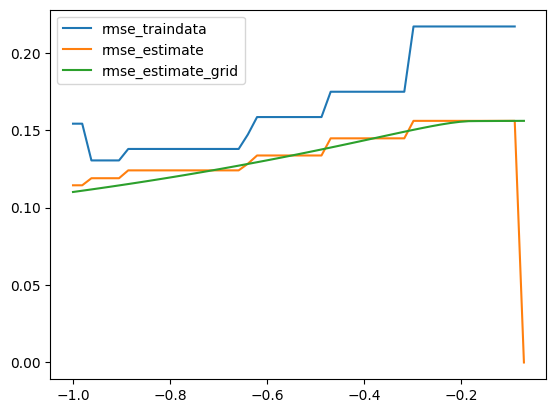

In [106]:
"""
mean,   std,    n_samples,  noise_std
[
    (-0.6, 0.3, 10, 0.1),
    (0.3, 0.5, 5, 0.2),
    (0.7, 0.2, 10, 0.1),
],
"""

with open('test/rmse.csv', 'r') as f:
    titles = f.readline()
    lines = f.readlines()
    lines = [line.strip().split(',') for line in lines]
    lines = [[float(x) for x in line] for line in lines]
    lines = np.array(lines)
    #rmse_traindata,rmse_estimate,rmse_estimate_grid
    plt.plot(lines[:, 0], lines[:, 2], label='rmse_traindata')
    plt.plot(lines[:, 0], lines[:, 3], label='rmse_estimate')
    plt.plot(lines[:, 0], lines[:, 4], label='rmse_estimate_grid')
    plt.legend()
    plt.show()


In [128]:
with open('test/rmse_parem.csv', 'w+') as f:
    f.write('start,end,rmse_traindata,rmse_estimate,rmse_estimate_grid\n')
    end = 1
    for start in np.linspace(-1.0, 1, 50):
        alls = all_rmses(model, X_train, y_train, start, end, fn=lambda x: x**2, steps=5000)
        f.write(f'{start},{end},{alls[0]},{alls[1]},{alls[2]}\n')
        #print(start, all_rmses(model, X_train, y_train, start, -0.069, fn=lambda x: x**2, steps=5000))

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


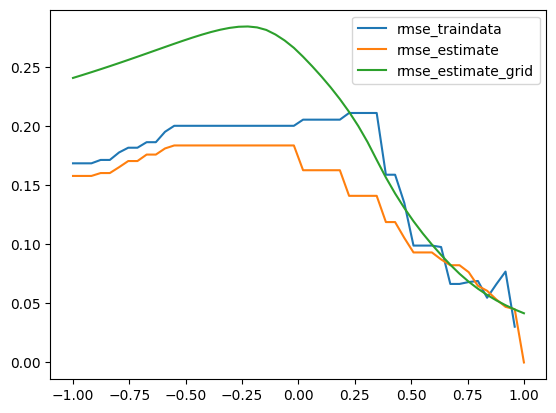

In [129]:
"""
mean,   std,    n_samples,  noise_std
[
    (-0.8, 0.1, 10, 0.1),
    (0.5, 0.2, 10, 0.3),
    (0.9, 0.1, 10, 0.1),
],
"""

with open('test/rmse_parem.csv', 'r') as f:
    titles = f.readline()
    lines = f.readlines()
    lines = [line.strip().split(',') for line in lines]
    lines = [[float(x) for x in line] for line in lines]
    lines = np.array(lines)
    #rmse_traindata,rmse_estimate,rmse_estimate_grid
    plt.plot(lines[:, 0], lines[:, 2], label='rmse_traindata')
    plt.plot(lines[:, 0], lines[:, 3], label='rmse_estimate')
    plt.plot(lines[:, 0], lines[:, 4], label='rmse_estimate_grid')
    plt.legend()
    plt.show()


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


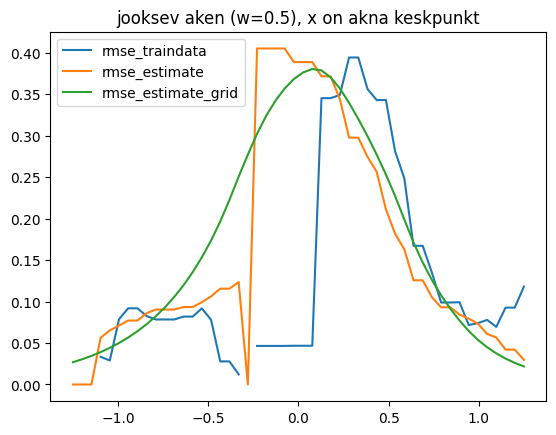

In [131]:
with open('test/rmse_parem2.csv', 'w+') as f:
    f.write('start,end,rmse_traindata,rmse_estimate,rmse_estimate_grid\n')
    end = 1
    for start in np.linspace(-1.5, 1, 50):
        alls = all_rmses(model, X_train, y_train, start, start+0.5, fn=lambda x: x**2, steps=5000)
        f.write(f'{start},{start+0.5},{alls[0]},{alls[1]},{alls[2]}\n')
        #print(start, all_rmses(model, X_train, y_train, start, -0.069, fn=lambda x: x**2, steps=5000))

"""
mean,   std,    n_samples,  noise_std
[
    (-0.8, 0.1, 10, 0.1),
    (0.5, 0.2, 10, 0.3),
    (0.9, 0.1, 10, 0.1),
],
"""

with open('test/rmse_parem2.csv', 'r') as f:
    titles = f.readline()
    lines = f.readlines()
    lines = [line.strip().split(',') for line in lines]
    lines = [[float(x) for x in line] for line in lines]
    lines = np.array(lines)
    #rmse_traindata,rmse_estimate,rmse_estimate_grid
    plt.plot(lines[:, 0]+0.25, lines[:, 2], label='rmse_traindata')
    plt.plot(lines[:, 0]+0.25, lines[:, 3], label='rmse_estimate')
    plt.plot(lines[:, 0]+0.25, lines[:, 4], label='rmse_estimate_grid')
    plt.title("jooksev aken (w=0.5), x on akna keskpunkt")
    plt.legend()
    plt.show()


313/313 [==============================] - 2s 5ms/step
model contains 7 breaks
313/313 [==============================] - 1s 5ms/step


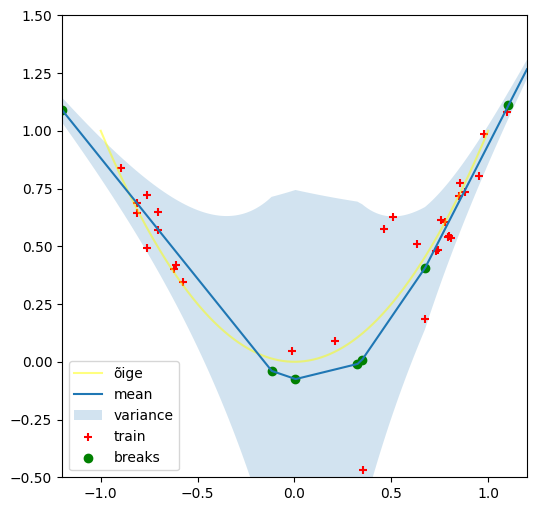

In [153]:
utils.joonista_variance(model, X_valid, X_train, y_train, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))

## Muutuva müraga andmed

313/313 [==============================] - 2s 6ms/step
model contains 7 breaks
313/313 [==============================] - 2s 5ms/step


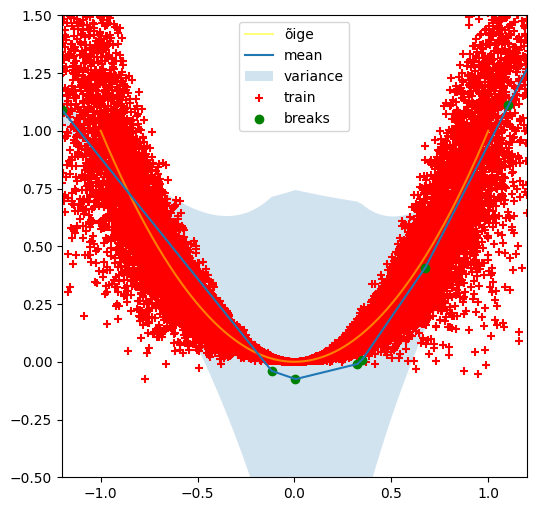

In [152]:
def train_data_maker2(elements:list[tuple[float, float, float, float]], fn=lambda x: x**2, seed=0) -> tuple[np.array, np.array]:
    """Loob treeningandmed, võtab sisse listi, kus iga element on tuple:
        - mean
        - std
        - n_samples
        - noise_std

    :param elements: list of tuples, where each tuple is (mean, std, n_samples, noise_std)
    :param fn: f(x), funktsioon, defaults to lambdax:x**2
    :return: treeningandmed
    """    
    utils.reset_seeds(seed)


    X, y = [], []
    for el in elements:
        xi = np.random.normal(el[0], el[1], size=el[2])
        yi = fn(xi) + np.random.normal(0, 0.3*np.abs(xi)**2, size=el[2])
        X.extend(xi)
        y.extend(yi)
    X, y = np.array(X), np.array(y)
    return X, y

a,b=train_data_maker2([
    (x/1000, 0.2, 10, 0.1) for x in range(-1000, 1000)
],)
utils.joonista_variance(model, X_valid, a, b, ground_truth=lambda x:x**2, xlim=(-1.2, 1.2), ylim=(-0.5, 1.5))